In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import linalg as LA
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
from src import SmoothSailingAE, kappa, AutoEncoder
import pickle

In [8]:
args = SimpleNamespace(batch_size=32, test_batch_size=1000, epochs=50,
                       lr=0.005, momentum=0.5, seed=1, log_interval=100, noise_level=1, beta_end=0.1, beta_mid=0.005)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [9]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

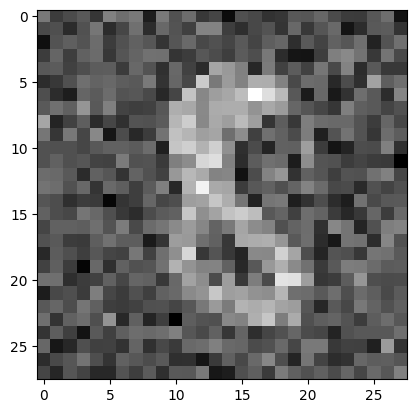

In [10]:
# add some noise to the data
data, train_labels = next(iter(train_loader))
noisy_data = data + args.noise_level * torch.randn(data.shape)
show_img = noisy_data[1][0].numpy()
input_dim = data[1].shape[1] * data[1].shape[2]
plt.imshow(show_img, cmap='gray')
plt.show()

In [11]:
torch.manual_seed(args.seed)
model = AutoEncoder().to(device)
sail = SmoothSailingAE(beta_end=0.01, beta_mid=0.0001)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

torch.manual_seed(args.seed)
model_reg = AutoEncoder().to(device)
smoothsail = SmoothSailingAE(beta_end=0.1, beta_mid=0.005)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=args.lr)
#optim.SGD(model_reg.parameters(), lr=args.lr, momentum=args.momentum)

In [13]:
fit = []
fit_val = []
fit_reg = []
fit_reg_val = []

cond_enc = []
cond_mid1 = []
cond_mid2 = []
cond_dec = []
cond_enc_reg = []
cond_mid1_reg = []
cond_mid2_reg = []
cond_dec_reg = []

W1 = model.linear1.weight.data
M1 = model.middle1.weight.data
M2 = model.middle2.weight.data
W2 = model.linear2.weight.data
cond_enc.append(kappa(W1))
cond_mid1.append(kappa(M1))
cond_mid2.append(kappa(M2))
cond_dec.append(kappa(W2))

W1_reg = model_reg.linear1.weight.data
M1_reg = model_reg.middle1.weight.data
M2_reg = model_reg.middle2.weight.data
W2_reg = model_reg.linear2.weight.data
cond_enc_reg.append(kappa(W1_reg))
cond_mid1_reg.append(kappa(M1_reg))
cond_mid2_reg.append(kappa(M2_reg))
cond_dec_reg.append(kappa(W2_reg))

print(f"Init condition numbers:")
print(f"\tCondition numbers {cond_enc[-1]:.2f}", f"{cond_mid1[-1]:.2f}", f"{cond_mid2[-1]:.2f}", f"{cond_dec[-1]:.2f}")
print(f"\tReguarized condition numbers {cond_enc_reg[-1]:.2f}", f"{cond_mid1_reg[-1]:.2f}", f"{cond_mid2_reg[-1]:.2f}", f"{cond_dec_reg[-1]:.2f}")

# train and evaluate

for epoch in range(args.epochs):
    running_loss = 0.0
    running_loss_reg = 0.0

    running_val_loss = 0.0
    running_val_loss_reg = 0.0

    model.train()
    model_reg.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        noisy_data = data + args.noise_level * torch.randn(data.shape)
        data = Variable(data.view(-1, input_dim))
        target = Variable(noisy_data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)

        output = model(data)
        W1 = model.linear1.weight
        M1 = model.middle1.weight
        M2 = model.middle2.weight
        W2 = model.linear2.weight
        loss, loss_regu = sail(output, target, W1, M1, M2, W2)
        optimizer.zero_grad()
        loss_regu.backward()
        optimizer.step()

        output_reg = model_reg(data)
        W1 = model_reg.linear1.weight
        M1 = model_reg.middle1.weight
        M2 = model_reg.middle2.weight
        W2 = model_reg.linear2.weight
        loss_bas, loss_reg = smoothsail(output_reg, target, W1, M1, M2, W2)
        optimizer_reg.zero_grad()
        loss_reg.backward()
        optimizer_reg.step()

        running_loss += loss.item()
        running_loss_reg += loss_bas.item()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss_reg: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss_bas.item()))


    model.eval()
    model_reg.eval()

    with torch.no_grad():
        for data, target in test_loader:
            noisy_data = data + args.noise_level * torch.randn(data.shape)
            data = Variable(data.view(-1, input_dim))
            target = Variable(noisy_data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)

            output = model(data)
            W1 = model.linear1.weight
            M1 = model.middle1.weight
            M2 = model.middle2.weight
            W2 = model.linear2.weight
            loss, loss_regu = sail(output, target, W1, M1, M2, W2)

            output_reg = model_reg(data)
            W1 = model_reg.linear1.weight
            M1 = model_reg.middle1.weight
            M2 = model_reg.middle2.weight
            W2 = model_reg.linear2.weight
            loss_bas, loss_reg = smoothsail(output_reg, target, W1, M1, M2, W2)

            running_val_loss += loss.item()
            running_val_loss_reg += loss_bas.item()

    W1 = model.linear1.weight.data
    M1 = model.middle1.weight.data
    M2 = model.middle2.weight.data
    W2 = model.linear2.weight.data
    cond_enc.append(kappa(W1))
    cond_mid1.append(kappa(M1))
    cond_mid2.append(kappa(M2))
    cond_dec.append(kappa(W2))

    W1_reg = model_reg.linear1.weight.data
    M1_reg = model_reg.middle1.weight.data
    M2_reg = model_reg.middle2.weight.data
    W2_reg = model_reg.linear2.weight.data
    cond_enc_reg.append(kappa(W1_reg))
    cond_mid1_reg.append(kappa(M1_reg))
    cond_mid2_reg.append(kappa(M2_reg))
    cond_dec_reg.append(kappa(W2_reg))

    fit.append(running_loss/len(train_loader.dataset))
    fit_val.append(running_val_loss/args.test_batch_size)
    fit_reg.append(running_loss_reg/len(train_loader.dataset))
    fit_reg_val.append(running_val_loss_reg/args.test_batch_size)


    print(f"Epoch {epoch+1}/{args.epochs}:")
    print(f"\tLoss: {fit[-1]:.2f} with condition numbers {cond_enc[-1]:.2f}", f"{cond_mid1[-1]:.2f}", f"{cond_mid2[-1]:.2f}", f"{cond_dec[-1]:.2f}")
    print(f"\tRegularized Loss: {fit_reg[-1]:.2f} with condition numbers {cond_enc_reg[-1]:.2f}", f"{cond_mid1_reg[-1]:.2f}", f"{cond_mid2_reg[-1]:.2f}", f"{cond_dec_reg[-1]:.2f}")

torch.save(model.state_dict(), "model_denoise_FIN_01.pt")
torch.save(model_reg.state_dict(), f"model_denoise_FIN_001.pt")

Init condition numbers:
	Condition numbers 3.66 2.04 1.98 3.51
	Reguarized condition numbers 3.66 2.04 1.98 3.51
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.231110	Loss_reg: 2.231110
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.599777	Loss_reg: 1.622359
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.665528	Loss_reg: 1.662354
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.612630	Loss_reg: 1.609503
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.597723	Loss_reg: 1.614106
Train Epoch: 0 [16000/60000 (27%)]	Loss: 1.550694	Loss_reg: 1.569934
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.588922	Loss_reg: 1.614532
Train Epoch: 0 [22400/60000 (37%)]	Loss: 1.604105	Loss_reg: 1.628711
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.552196	Loss_reg: 1.574910
Train Epoch: 0 [28800/60000 (48%)]	Loss: 1.548217	Loss_reg: 1.567704
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.541234	Loss_reg: 1.565919
Train Epoch: 0 [35200/60000 (59%)]	Loss: 1.537337	Loss_reg: 1.566151
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.556627	Loss_reg: 1.586410

In [142]:

# save results
results = {
    "fit": fit,
    "fit_val": fit_val,
    "fit_reg": fit_reg,
    "fit_reg_val": fit_reg_val,
    "cond_enc": cond_enc,
    "cond_mid1": cond_mid1,
    "cond_mid2": cond_mid2,
    "cond_dec": cond_dec,
    "cond_enc_reg": cond_enc_reg,
    "cond_mid1_reg": cond_mid1_reg,
    "cond_mid2_reg": cond_mid2_reg,
    "cond_dec_reg": cond_dec_reg
}

with open("results_denoise_FIN.pkl", "wb") as f:
    pickle.dump(results, f)

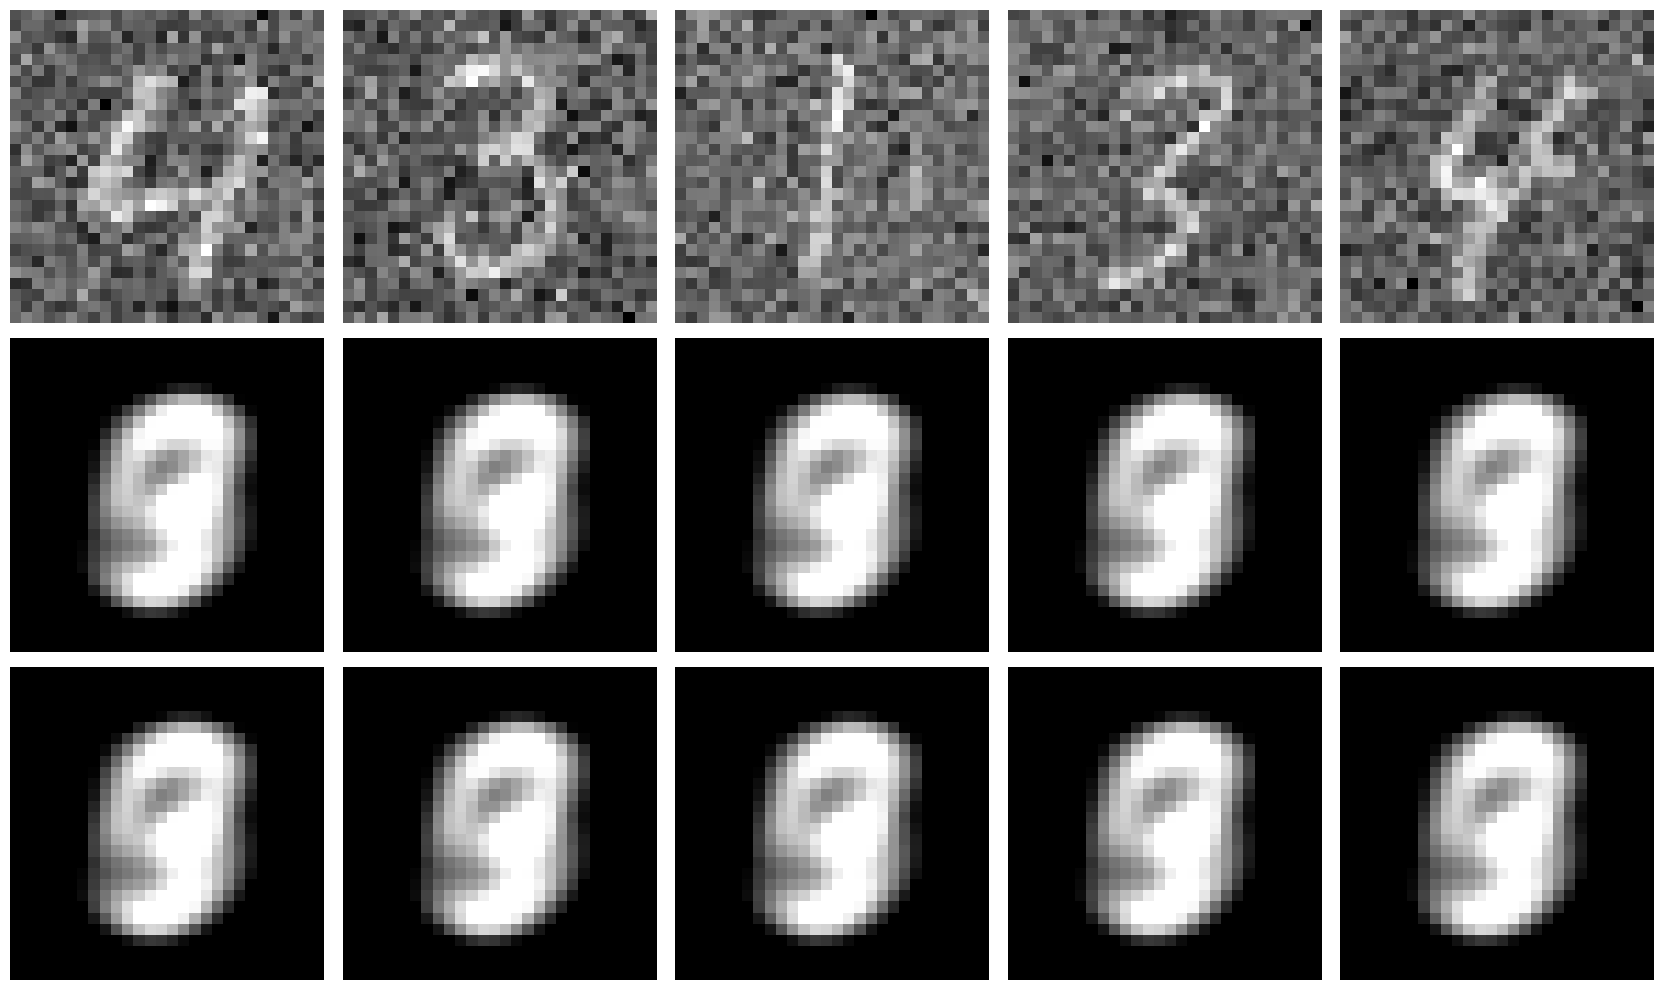

In [144]:
# plot denoised images
plt.figure(figsize=(60,10))

for i in range(5):
    data, train_labels = next(iter(train_loader))
    noisy_data = data[i][0] + args.noise_level * torch.randn(data[i][0].shape)
    output = model(noisy_data.view(-1, input_dim)).view(28, 28).cpu().detach().numpy()
    output_reg = model_reg(noisy_data.view(-1, input_dim)).view(28, 28).cpu().detach().numpy()

    plt.subplot(3, 18, i+1)
    plt.imshow(noisy_data.cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 18, i+19)
    plt.imshow(output, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 18, i+37)
    plt.imshow(output_reg, cmap='gray')
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
#plt.savefig('MNIST_denoising.png')
plt.show()

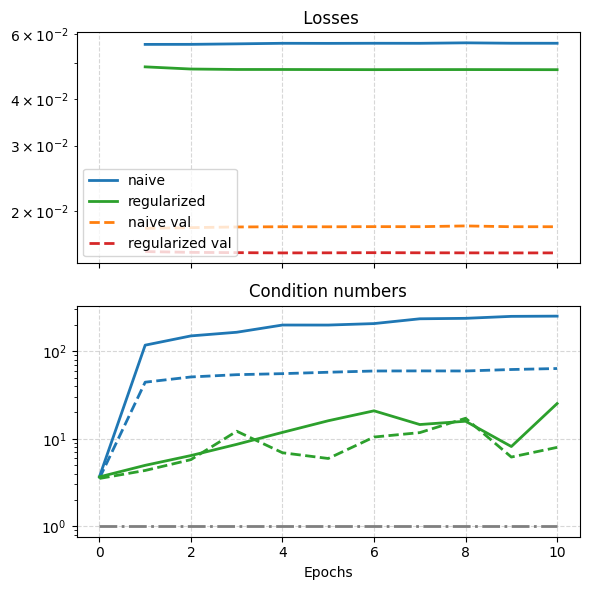

In [62]:
plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
Ts = np.arange(0, args.epochs+1)

ax = axes[0]
ax.plot(Ts[1:], fit, 'tab:blue', linewidth=2, label='naive')
ax.plot(Ts[1:], fit_reg, 'tab:green', linewidth=2, label='regularized')
ax.plot(Ts[1:], fit_val, 'tab:orange', linewidth=2, linestyle='--', label='naive val')
ax.plot(Ts[1:], fit_reg_val, 'tab:red', linewidth=2, linestyle='--', label='regularized val')

ax.set_yscale('log')
ax.set_title(' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, cond_enc, 'tab:blue', linewidth=2)
ax.plot(Ts, cond_dec, 'tab:blue', linewidth=2, linestyle='--')
ax.plot(Ts, cond_enc_reg, 'tab:green', linewidth=2)
ax.plot(Ts, cond_dec_reg, 'tab:green', linewidth=2, linestyle='--')
ax.plot(Ts, np.ones(len(Ts)), 'tab:gray', linewidth=2, label='Tightened', linestyle='-.')
ax.set_yscale('log')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='lower left')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fit_MNIST.pdf', bbox_inches='tight')

In [145]:
# open pickle file
with open("results_denoise_tik.pkl", "rb") as f:
    results_all = pickle.load(f)

In [148]:
results_all['cond_enc'][-1], results_all['cond_mid1'][-1], results_all['cond_mid2'][-1], results_all['cond_dec'][-1]

(1277.2064894470823, 31641.66099214065, 20358.699784417637, 5347.090651298175)

In [149]:
results_all['cond_enc_reg'][-1], results_all['cond_mid1_reg'][-1], results_all['cond_mid2_reg'][-1], results_all['cond_dec_reg'][-1]

(12.802150564158183, 1.4299894825923616, 2.6547604925935957, 6061.528090578038)